# First-Levels
## Filtering & Normalizing
In preprocessing BOLD fMRI data, one common source of noise is the low-frequency trends. The presence of low-frequency contamination can be identified by visualizing the power spectrum of the BOLD signal. The power spectrum density of BOLD fMRI data typically exhibits the classic inverse-frequency (1/f) function. Soures of low-frequency may include cardiac/respiratory effects and the scanner itself (for an overview, see [Poldrack et al. (2011)](http://www.fmri-data-analysis.org/)).

Irrespective of source, low-frequency trends are removed via high-pass filters. There are many approaches to high-pass filtering BOLD fMRI data. Certain software packages use a discrete cosine transform (DCT) basis set (e.g. SPM, Freesurfer). With the DCT basis set, a series of cosines of different frequencies are generated and included in the first-level design matrix. The highest frequency cosine corresponds to the highest frequency for removal. [Poldrack et al. (2011)](http://www.fmri-data-analysis.org/) argue that, "as a rough rule of thumb, the longest period of the drift DCT basis should be at least twice the period of an on–off block design." 

A second approach is to use a locally weighted scatterplot smoothing (LOWESS) model to remove slow trends from the data. This approach is employed by FSL. The LOWESS model uses local linear regression over a window to identify low-frequency trends, which are then subtracted out. The larger the window, the higher the frequencies that are filtered out. [Poldrack et al. (2011)](http://www.fmri-data-analysis.org/) demonstrate that the DCT basis function and LOWESS approaches yield very similar results in the time-domain.

A third approach is to use digital filters, such as infinite impulse response (IIR) filters. One benefit of IIR filters over DCT basis set filtering is that it guarantees high-pass filtering even if the low-frequency trends are out of phase. A second benefit is that digital filters are applied outside of the deisgn matrix, reducing the possibility of introducing collinearity into the deisgn matrix. One issue is with high-pass filters, however, is that they assume no 0th-order trend (i.e. the data has been detrended). This assumption is often incompatible with fMRI data, where the signal offset is needed to compute the percent signal change (PSC). 

Below we demonstrate an implementation of high-pass filtering with a digital filter (i.e. Butterworth IIR) that overcomes this issue by (1) storing the signal offset; (2) detrending and filtering the signal; and (3) adding back the offset. Note that this solution is described [elsewhere](https://github.com/nilearn/nilearn/issues/374).

To do this, we simulate a simple BOLD fMRI timeseries. Our simulated timeseries is of a simple slow-event related fMRI task. We simulate a response to 50 blocks of 21 seconds, where each block is comprised of 3.5s of stimulus followed by 17.5s of null time. The long tails of null time are to let the BOLD response settle. In addition, 21 seconds of null time before included before the first and after the last blocks. The TR for this task is identical to ARC: 1.75s. Importantly, we assume a BOLD response of 1% signal change and a signal offset of 100. If our filtering and normalization procedures are effective, we should observe a final regression with an estimated BOLD fMRI percent signal change of 1%. 

### Generate BOLD Template

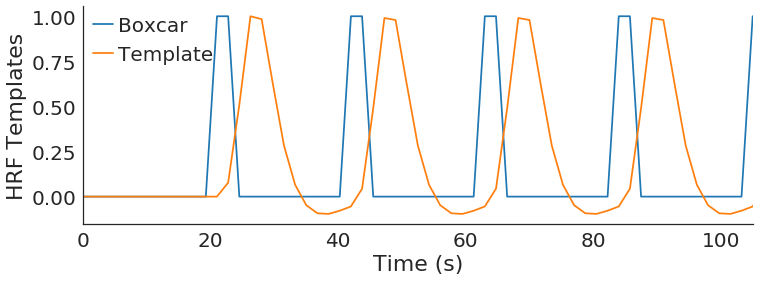

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scripts.spm_hrf import *
sns.set_style('white')
sns.set_context('notebook', font_scale=2)
%matplotlib inline

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Task parameters.
tr = 1.75
n_blocks = 50 
block_length = 21 #s

## BOLD response paramaters.
psc = 0.01
offset = 100

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define BOLD template.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Compute number of TRs per block.
acq_per_block = int(block_length / tr)

## Define a simple block (21s total; 3.5s stimulus, 17.5s null)
block = np.zeros(acq_per_block)
block[:2] += 1

## Concatenate 50 blocks.
boxcars = np.concatenate([block for _ in range(n_blocks)])

## Prepend/append 21s of null time before/after blocks.
boxcars = np.concatenate([np.zeros(acq_per_block),boxcars,np.zeros(acq_per_block)])

## Convolve boxcars with SPM HRF. 
times = np.arange(boxcars.shape[0]) * tr
template = np.convolve(boxcars, spm_hrf(1.75))
template = template[:times.shape[0]] # Enforce length
template /= template.max()           # Normalize to height one.

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Plot.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
fig, ax = plt.subplots(1,1,figsize=(12,4))

ax.plot(times, boxcars, label='Boxcar')
ax.plot(times, template, label='Template')
ax.set(xlim=(0,block_length*5), xlabel='Time (s)', ylabel='HRF Templates')
ax.legend(loc=2, borderpad=0, handlelength=1, handletextpad=0.25)
sns.despine()

### Simulate BOLD Data
For realism, we add 0th-3rd order trends.

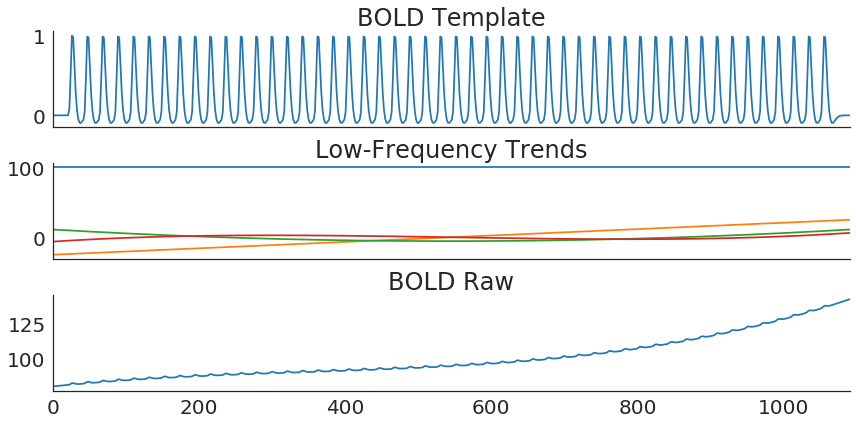

In [2]:
from scipy.special import legendre

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define drifts.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
## We include the 0th through 3rd order polynomials as trends. 
## Note: the 0th-order polynomial is the BOLD offset.

## Preallocate space.
n_times = times.shape[0]
n_order = 4

## Generate trend templates.
polynomials = np.array([legendre(n)(np.linspace(-1,1,n_times)) for n in np.arange(n_order)]).T

## Set trend power (approx 1/f rule).
powers = offset / np.arange(1,5) ** 2
drifts = polynomials.dot(np.diag(powers))

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Simulate BOLD data.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Step 1: Normalize BOLD max amplitude
## as specified PSC of offset.
bold_raw = template.copy()
bold_raw *= psc * offset 

## Step 2: Add trends.
bold_raw += drifts.sum(axis=1)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Plot.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

fig, axes = plt.subplots(3,1,figsize=(12,6),sharex=True)
titles = ['BOLD Template','Low-Frequency Trends','BOLD Raw']

axes[0].plot(times, template)
axes[1].plot(times, drifts)
axes[2].plot(times, bold_raw)
for ax, title in zip(axes,titles): ax.set(xlim=(0,times[-1]), title=title)
sns.despine()
plt.tight_layout()

### Filter BOLD Data

/home/szoro/Documents/software/anaconda3.6/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/home/szoro/Documents/software/anaconda3.6/lib/python3.6/site-packages/ipykernel_launcher.py:10: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  # Remove the CWD from sys.path while we load stuff.


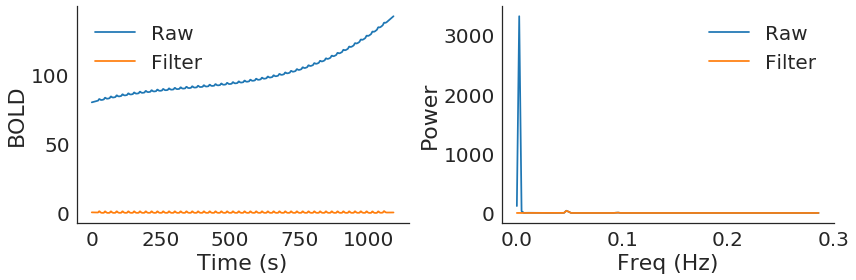

In [3]:
from mne.time_frequency import psd_array_welch
from nilearn.signal import clean

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Estimate offset.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
## Use the Legendre polynomials to compute more
## robust estimate of the average signal.

b, _, _, _ = np.linalg.lstsq(polynomials, bold_raw)
mu = b[0]

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Filter data.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
## clean expects [n_time,n_voxels]

bold_raw = np.expand_dims(bold_raw.squeeze(), 0)
bold_filter = clean(bold_raw.T, detrend=True, standardize=False, 
                    high_pass=0.01, t_r=tr).T

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Plot.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

fig, axes = plt.subplots(1,2,figsize=(12,4))

for bold, label in zip([bold_raw, bold_filter],['Raw','Filter']):
    
    ## Plot BOLD.
    axes[0].plot(times, bold.squeeze(), label=label)

    ## Compute and plot PSD.
    psds, freqs = psd_array_welch(bold, 1/tr, verbose=False)
    axes[1].plot(freqs,psds.squeeze(), label=label)
    

axes[0].set(xlabel='Time (s)', ylabel='BOLD')
axes[0].legend()
axes[1].set(xlabel='Freq (Hz)', ylabel='Power')
axes[1].legend()
sns.despine()
plt.tight_layout()

### Normalization & Regression

/home/szoro/Documents/software/anaconda3.6/lib/python3.6/site-packages/ipykernel_launcher.py:22: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


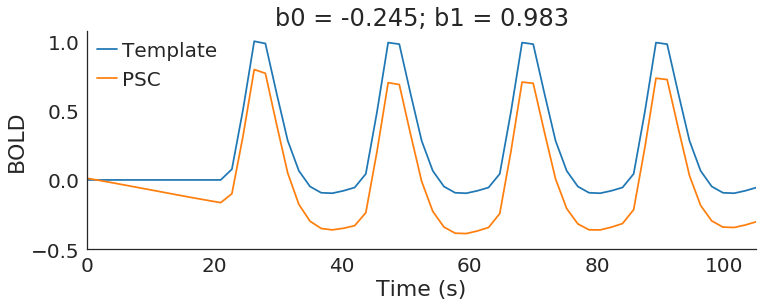

In [4]:
from nitime.timeseries import TimeSeries
from nitime.analysis import NormalizationAnalyzer

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Normalization (PSC)
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
## Normalize BOLD to percent signal change
## Note: we add offset back to filtered data.

ts = TimeSeries(bold_filter + mu, sampling_interval=tr)
psc = NormalizationAnalyzer(ts).percent_change.data.squeeze()

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Regression
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Generate design matrix.
X = np.vstack([np.ones_like(template), template]).T
y = psc.copy()

## Perform OLS.
b, _, _, _ = np.linalg.lstsq(X,y)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Plot.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
fig, ax = plt.subplots(1,1,figsize=(12,4))

ax.plot(times, template, label='Template')
ax.plot(times, psc, label='PSC')
ax.set(xlim=(0,block_length*5), xlabel='Time (s)', ylabel='BOLD',
       title='b0 = %0.3f; b1 = %0.3f' %(b[0],b[1]))
ax.legend(loc=2, borderpad=0, handlelength=1, handletextpad=0.25)
sns.despine()

## Pre-whitening
Even with high-pass filtering, BOLD fMRI data are still autocorrelated. In order to satisfy the i.i.d. assumption of the residuals in ordinary least squares (OLS), and consequently for model estimates to have minimal variance and bias, autocorrelation must be removed. 

Pre-whitening is a standard step in fMRI preprocessing to remove autocorrelation. In essence, it is completed in two steps:
1. The GLM is fit (ignoring autocorrelation) and the residuals are obtained. The residuals are then used to estimate the autocorrelation structure.
2. The GLM is reestimated after pre-multiplying (pre-whitening) the design matrix and BOLD fMRI time series by a derivative of the autocorrelation matrix.

[Poldrack et al. (2011, Appendix A)](http://www.fmri-data-analysis.org/) lay out in beautiful detail the mathematics of pre-whitening. In the absence of temporal autocorrelation, the formula for ordinary least squares linear regression is:
> $Y = X\beta + \epsilon $

which can be rewritten to solve for the coefficients: 
> $\beta = (X^{T}X)^{-1}X^{T}Y$

With pre-whitening, however, the formulas change to incorporate a whitening matrix, $W$:
> $Y^* = X^*\beta + \epsilon^*$

where $Y^*=WY$, $X^*=WX$, and $\epsilon^*=W\epsilon$. This new formulas can be rearranged to solve for the coefficients:

> $\beta = (X^{*T}X^*)^{-1}X^{*T}Y^*$

Finally, the standard errors for the coefficients can be calculated from:
> $Cov(\beta) = (X^{*T}X^*)^{-1}\sigma^2$

where $\sigma^2$ is the mean squared error:
> $\sigma^2 = \frac{\epsilon^T\epsilon}{N-p}$

> $\epsilon = Y^* - X^*\beta$

and $N$ is the number of observations and $p$ is the number of regressors.

The challenge then is in finding the whitening matrix $W$. Fortunately, the whitening matrix has a direct relation to the temporal autocorrelation matrix, $V$:
> $V^{-1} = W^TW$

In other words, the whitening matrix $W$ is the inverse square root of the autocorrelation matrix. This allows for a straightforward approach to solve for $W$.

#### Step 1: Compute residuals
We follow the equations outlined above:
> $Y = X\beta + \epsilon$

where the formula can be rearranged to solve for the coefficients:
> $\beta = (X^{T}X)^{-1}X^{T}Y$

Once the coefficients are obtained, the residuals are easily computed:
> $\epsilon = y - X\beta$

#### Step 2: Estimate autocorrelation matrix, $V$
The autocorrelation matrix $V$ is a banded square matrix with diagonals set to 1, and off-diagonals set to the correlation of the residuals at lag $N$. In other words, for a first-order autocorrelation matrix, the main diagonal will all equal 1 and the first off-diagonals will be equal to:
> $AC_1 = Corr(\epsilon_{1...N-1}, \epsilon_{2...N})$

Most software packages compute only the first-order autocorrelation, though several studies have suggested to use higher-order models ([Lenoski et al., 2008](https://www.researchgate.net/profile/Josef_Debbins/publication/224368400_On_the_Performance_of_Autocorrelation_Estimation_Algorithms_for_fMRI_Analysis/links/0deec5217b18315500000000.pdf); [Eklund et al., 2012](https://www.ncbi.nlm.nih.gov/pubmed/22507229)). 

#### Step 3: Estimate the whitening matrix ($W$)
Estimating the whitening matrix, $W$, is often the least transparent step in discussions of pre-whitening. There are many ways to calculate a whitening matrix ([Kessy et al., 2015;](https://arxiv.org/pdf/1512.00809.pdf) [Mejia, 2017](https://mandymejia.wordpress.com/2016/11/06/how-to-efficiently-prewhiten-fmri-timeseries-the-right-way/)). Here we will make use of two approaches: the Cholesky decomposition and singular value decomposition (SVD). The strength of the Cholesky decomposition its speed, but its weakness is in requiring positive semi-definite matrices. In contrast, SVD is slow but will handle any square matrix. For most correlation matrices, the Cholesky decomposition will work fine and will yield substantial speedups in pre-whitening. But for those correlation matrices for whom the Cholesky decomposition will not work, the slower SVD can be used. 

Remember that the whitening matrix is the inverse square root of the autocorrelation matrix ($V^{-1} = W^TW$). Using the Cholesky decomposition, we can solve for $W$ from $V$ as follows ([ref](https://multivariatestatsjl.readthedocs.io/en/latest/whiten.html)):
> $V = U^TU$

> $V^{-1} = (U^{-1})(U^{-1})^T$

> $W = U^{-1}$

With SVD, the procedure is similar:

> $U, S, Vh = SVD(V)$

> $W = U(S^{-\frac{1}{2}})Vh$

Once $W$ is obtained, OLS with pre-whitening can be estimated using the equations outlined above.

### Simulate Data
We demonstrate the prewhitening procedure below with simulated autocorrelated data.

/home/szoro/Documents/software/anaconda3.6/lib/python3.6/site-packages/ipykernel_launcher.py:44: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


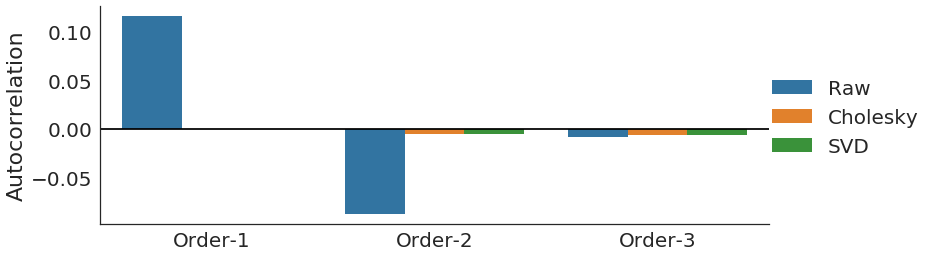

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import DataFrame
from scripts.first_levels import *
sns.set_style('white')
sns.set_context('notebook', font_scale=2)
%matplotlib inline

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Simulation parameters.
n_samples = 200
ac1 = 0.2

## Model parameters.
ac_order = 3

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Simulate data.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
def zscore(arr): return (arr - arr.mean()) / arr.std()
np.random.seed(47404)

## Preallocate space for autocorrelation coefficients.
AC = np.zeros((3,ac_order))

## Define source autocorrelation matrix.
cov = np.identity(n_samples)
cov += np.diag(np.ones(n_samples - 1) * ac1, -1) +\
       np.diag(np.ones(n_samples - 1) * ac1, -1).T
    
## Simulate data.
y = np.random.multivariate_normal(mean=np.zeros(n_samples), cov=cov, size=1).squeeze()
y += zscore(np.arange(n_samples))

## Define design matrix.
X = np.concatenate([np.ones_like(y).reshape(-1,1),
                    zscore(np.arange(n_samples)).reshape(-1,1)],
                   axis=-1)

## Step 1: Estimate residuals.
b, _, _, _ = np.linalg.lstsq(X,y)
residuals = y - X.dot(b)

## Step 2: Compute correlation matrix.
V = autocorrelate(residuals, ac_order)

## Step 3: Estimate whitening matrix.
Wcho = cholesky_whitening(V)
Wsvd = svd_whitening(V)

## Step 4: Estimate OLS.
for n, W in enumerate([np.identity(n_samples), Wcho, Wsvd]):
    
    Xs = W.dot(X.copy())
    Ys = W.dot(y.copy())
    b = ols(Ys, Xs)
    residuals = Ys - Xs.dot(b)
    AC[n] = autocorrelate(residuals, ac_order)[0,1:ac_order+1]

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Plotting.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Conver to DataFrame.
AC = DataFrame(AC, columns=('Order-%s' %n for n in np.arange(ac_order)+1), 
               index=('Raw','Cholesky','SVD'))
AC = AC.reset_index().melt(id_vars='index')

## Plot.

fig, ax = plt.subplots(1,1,figsize=(12,4))
sns.barplot('variable', 'value', 'index', AC, ax=ax)
ax.set(xlabel='', ylabel='Autocorrelation')
x1, x2 = ax.get_xlim()
ax.hlines(0,x1,x2)
ax.legend(loc=1, bbox_to_anchor=(1.25,0.75))
sns.despine()

# Second-Levels

The first analytic goal of the second-level analysis will be to identify voxels that significantly correlate with trial-by-trial variability in conflict. Using the FIR approach, first-level analysis will leave us with $N \cdot T$ number of coefficients, where $N$ is the number of participants and $T$ is the number of time windows in the FIR model. Following [Yarkoni et al. (2009)](http://journals.plos.org/plosone/article?id=10.1371/journal.pone.0004257), the appropriate procedure for testing for significant difference between conditions (i.e. time windows) is a repeated-measures one-way ANOVA with *time window* as the between-groups measure and *participant* as the within-group measure.

In the sections below, code and literature will be provided to demonstrate:
1. Estimating a repeated-measures one-way ANOVA
2. Permuting the ANOVA structure

Importantly, we deviate from [Yarkoni et al. (2009)](http://journals.plos.org/plosone/article?id=10.1371/journal.pone.0004257) in one important way: we do not correct for non-sphericity after estimating the ANOVA. This is not out of any statistical expediency, but simply because corrections for non-sphericity do not change the $F$ statistics, but instead the corresponding degrees of freedom ([ref](https://statistics.laerd.com/statistical-guides/sphericity-statistical-guide.php)). To perform permutation testing, we only care about the $F$ statistic of our second-level models. Consequently, corrections for non-sphericity are unnecessary. 

## Repeated Measures One-way ANOVA
Fortunately, the one-way repeated measures analysis of variance (ANOVA) is a fairly straightforward statistical procedure ([ref](https://statistics.laerd.com/statistical-guides/repeated-measures-anova-statistical-guide.php)). In the following demonstration, please assume the following: for some experiment, we have $K$ conditions and $J$ subjects. We assume a fully balanced design such that the total number of data points for each participant $j$ and condition $k$ is the same value, $I$. 

The $F$ statistic can ultimately be derived as follows:

> $F = \frac{MS_{between}}{MS_{error}}$

where $MS_{between}$ is the mean square difference between conditions, and $MS_{error}$ is the mean square error. Before solving for $F$, we must first solve for the between-groups term, $SS_{between}$, and the error term, $SS_{error}$.

The between-groups term, $SS_{between}$, is:

> $SS_{between} = \sum_{k=1}^{K} n_i(\bar{x_i}-\bar{x})^2$

where $\bar{x}$ is the grand mean, $\bar{x_k}$ is the mean of condition $k$, and $n_k$ is the number of data points in condition $k$. The error term, $SS_{error}$, can be calculated in several ways (though we will focus on the first):

> $SS_{error} = SS_{within} - SS_{subj}$

> $SS_{error} = SS_{total} - SS_{between} - SS_{subj}$

The within-groups term, $SS_{within}$, is:

> $SS_{within} = \sum_{k=1}^{K}\sum_{i=1}^{I}({x_{ik}}-\bar{x_k})^2$

where $\bar{x_k}$ is the mean for condition $k$, and ${x_{ik}}$ is $i$th data point for condition $k$. Finally, $SS_{subj}$ is:

> $SS_{subj} = k \cdot \sum(\bar{x_j}-\bar{x})^2$

where $k$ is the number of conditions, $\bar{x_j}$ is the mean for participant $j$, and $\bar{x}$ is the grand mean.

Once the the between-groups term, $SS_{between}$, and the error term, $SS_{error}$, are derived, their averages can be computed:

> $MS_{between} = \frac{SS_{between}}{df_{between}} = \frac{SS_{between}}{k-1}$

> $MS_{error} = \frac{SS_{between}}{df_{error}} = \frac{SS_{error}}{(j-1)(k-1)}$

where $j$ is the number of participants and $k$ is the number of conditions. Using the equation at the top, $F$ can be derived. Finally, a p-value can be derived from the $F$ distribution with the following degrees of freedom:

> $F(df_{between}, df_{error})$

### Simulate Data
[Source of data](https://statistics.laerd.com/statistical-guides/repeated-measures-anova-statistical-guide-2.php
)

Data shape: (6,3)


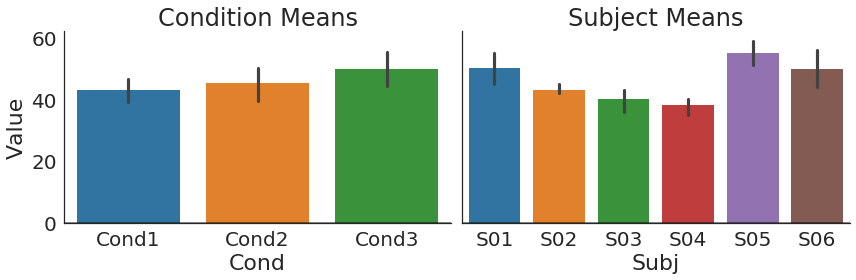

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import DataFrame
from scipy.stats import f as fdist
from spm1d.stats import anova1rm
sns.set_style('white')
sns.set_context('notebook', font_scale=2)
%matplotlib inline

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define data.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Define data.
data = [[45,50,55],
        [42,42,45],
        [36,41,43],
        [39,35,40],
        [51,55,59],
        [44,49,56]]
data = np.array(data)
J, K = data.shape

## Convert to DataFrame.
df = DataFrame(data, columns=('Cond1','Cond2','Cond3'), 
               index=['S%0.2d' %n for n in np.arange(J)+1])
df = df.reset_index().melt(id_vars='index')
df.columns = ['Subj','Cond','Value']
df = df.sort_values(['Subj','Cond'])

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Plot.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
fig, axes = plt.subplots(1,2,figsize=(12,4),sharey=True)
print('Data shape: (%s,%s)' %data.shape)

## Plot condition means.
sns.barplot(x='Cond', y='Value', data=df, ax=axes[0])
axes[0].set(title='Condition Means')
axes[0].hlines(0,-0.5,K+0.5,alpha=0.5)

## Plot subject means.
sns.barplot(x='Subj', y='Value', data=df, ax=axes[1])
axes[1].set(ylabel='',title='Subject Means')
axes[1].hlines(0,-0.5,J+0.5,alpha=0.5)
sns.despine()
plt.tight_layout()

### Repeated Measures One-way ANOVA (spm1d)

In [7]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Estimate ANOVA.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
## spm1d requires data to be a [NxM] structure,
## where N = total_cond * total_subj, and M =
## total_data_per_subj_cond.

## Gather data.
Y = df.Value.as_matrix()                          # Data matrix, [NxM]
_, A = np.unique(df.Cond, return_inverse=True)    # Condition index, [Nx1]
_, SUBJ = np.unique(df.Subj, return_inverse=True) # Subject index, [Nx1]

## Estimate ANOVA.
result = anova1rm(Y, A, SUBJ, equal_var=True)
print(result.inference(alpha=0.05))

SPM{F} (0D) inference
   SPM.effect   :  Main A
   SPM.SS       : (143.44444444444477, 57.222222222222214)
   SPM.df       : (2, 10)
   SPM.MS       : (71.72222222222238, 5.722222222222221)
   SPM.z        :  12.53398
Inference:
   SPM.alpha    :  0.050
   SPM.zstar    :  4.10282
   SPM.h0reject :  True
   SPM.p        :  0.00189




### Repeated Measures One-way ANOVA (by hand)

In [8]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Estimate ANOVA.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

grand_mean = data.mean()

## Compute SS_between.
f = lambda arr: len(arr) * (arr.mean() - grand_mean) ** 2
SS_b = np.apply_along_axis(f, 0, data).sum()

## Compute SS_within.
f = lambda arr: (arr - arr.mean())**2
SS_w = np.apply_along_axis(f, 0, data).sum()

## Compute SS_subjects.
SS_subj = K * np.power(data.mean(axis=1) - grand_mean,2).sum()

## Compute SS_error.
SS_err = SS_w - SS_subj

## Compute MS_between, MS_error.
df_b = (K - 1)
MS_b = SS_b / df_b

df_err = (J-1)*(K-1)
MS_err = SS_err / df_err

## Compute F, p.
F = MS_b / MS_err
p = fdist.sf(F, df_b, df_err)

## Print results.
print('SS: (%0.3f, %0.3f)' %(SS_b, SS_err))
print('MS: (%0.3f, %0.3f)' %(MS_b, MS_err))
print('df: (%s, %s)' %(df_b, df_err))
print('F = %0.3f, p = %0.3f' %(F,p))

SS: (143.444, 57.222)
MS: (71.722, 5.722)
df: (2, 10)
F = 12.534, p = 0.002


## Permutation Testing of ANOVA 
When performing permutation testing, one must assume the principle of exchangeability, which is equivalent to the assumption of independent and identically distributed (iid) random errors ([Anderson, 2001](https://www.uvm.edu/~dhowell/StatPages/R/RandomizationTestsWithR/Anderson%202001%20Permutation%20tests%20for%20univariate%20or%20multivariate%20analysis%20of%20variance%20and%20r_files/10535432.pdf)). If exchangeability is violated, then the permutation test is invalid. 

In the case of a one-way repeated measures ANOVA, obeying exchangeability is simple. Assuming a data matrix organized by *[observations, variables]*, the assumption of exchangeability applies to observations and (rows) and not variables (columns). In other words, an entire row of values is shuffled as a unit ([Anderson, 2001](https://www.uvm.edu/~dhowell/StatPages/R/RandomizationTestsWithR/Anderson%202001%20Permutation%20tests%20for%20univariate%20or%20multivariate%20analysis%20of%20variance%20and%20r_files/10535432.pdf)). This is  for two reasons:
1. Under the null hypothesis, it is the observations within subjects that are exchangeable, not the observations between subjects.
2. Within subjects, observations are likely to exhibit some non-zero correlation. They are not likely to be indepepdent, and are thus not exchangeable.

To demonstrate permutation testing, we use the same dataset defined above. With 3 variables, there are $3!=6$ possibile orders of observaions within a subject. With 6 subjects, that is $6^6=46656$ total possible permutations. We perform 5000 permutations below (ignoring possible repeats) and compare the consequent p-value to the result above.

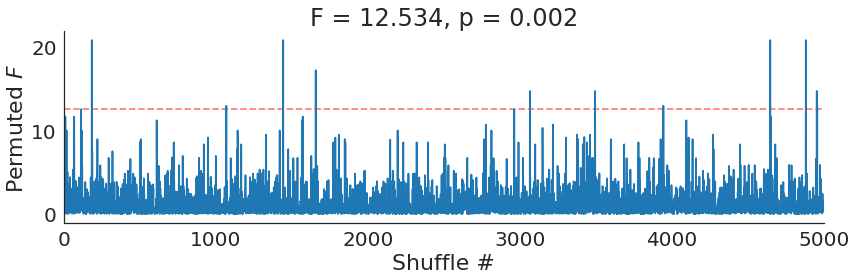

In [9]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Estimate ANOVA.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Gather data.
Y = df.Value.as_matrix()                          # Data matrix, [NxM]
_, A = np.unique(df.Cond, return_inverse=True)    # Condition index, [Nx1]
_, SUBJ = np.unique(df.Subj, return_inverse=True) # Subject index, [Nx1]

## Estimate ANOVA.
F_obs = anova1rm(Y, A, SUBJ, equal_var=True).z

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Permutation testing.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
np.random.seed(47404)

## This code requires the DataFrame to be 
## sorted by [Subject, Condition].
df = df.sort_values(['Subj','Cond'])

## Define parameters.
n_shuffles = 5000
shuffle = lambda x: np.random.choice(x, K, replace=False)

## Main loop. 
F_perm = np.zeros(n_shuffles)
for n in range(n_shuffles):

    ## Shuffle values. 
    Y_perm = np.concatenate(df.groupby('Subj').Value.apply(shuffle))
    
    ## Estimate ANOVA. Store F statistic.
    F_perm[n] = anova1rm(Y_perm, A, SUBJ, equal_var=True).z
    
## Compute p-value.
p = (F_perm > F_obs).sum() / (n_shuffles + 1.)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Plot.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

fig, ax = plt.subplots(1,1,figsize=(12,4))
ax.plot(F_perm)
ax.set(xlim=(0,n_shuffles),xlabel='Shuffle #',ylabel=r'Permuted $F$',
       title='F = %0.3f, p = %0.3f' %(F_obs, p))
ax.hlines(F_obs, 0, n_shuffles, color='r', linestyle='--', alpha=0.5)

sns.despine()
plt.tight_layout()

# Estimation of HRF Parameters
## Canonical HRF Parameters

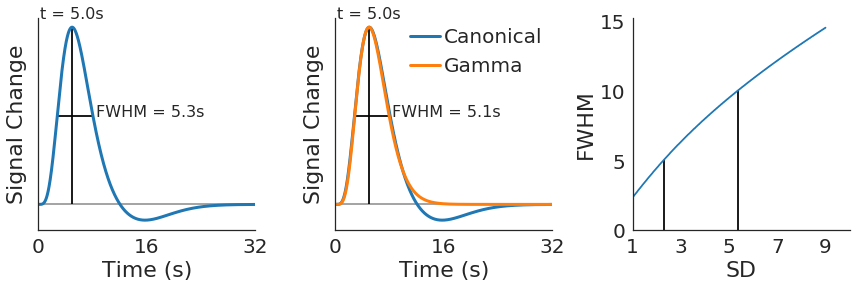

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import curve_fit
from scripts.spm_hrf import *
sns.set_style('white')
sns.set_context('notebook', font_scale=2)
%matplotlib inline

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Model canonical HRF.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Generate canonical HRF.
sfreq = 1e-2
y = spm_hrf(sfreq)
y /= y.max()
t = np.arange(0, 32+sfreq, sfreq)

## Idenity time-to-peak.
tpeak = t[y.argmax()]

## Identify full-width at half-maximum (FWHM).
t1, t2, fwhm = empirical_fwhm(t,y)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Plot canonical HRF.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

fig = plt.figure(figsize=(12,4))
ax = plt.subplot2grid((1,3),(0,0))

## Plot.
ax.plot(t, y, linewidth=3)
ax.hlines(0, 0, 32, alpha=0.4)
ax.set(xlim=(0,32), xticks=[0,16,32], xlabel='Time (s)', yticklabels=[], ylabel='Signal Change')

## Flourishes.
ax.vlines(tpeak, 0, y.max())
ax.text(tpeak, y.max()*1.05, 't = %0.1fs' %tpeak, ha='center', fontsize=16)
ax.hlines(y.max()/2, t1, t2)
ax.text(t2*1.05, y.max()/2, 'FWHM = %0.1fs' %fwhm, fontsize=16)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Model gamma HRF.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

def single_gamma_hrf(t, mode, sd):
    yhat = gamma(t, *to_sr(mode,sd))
    yhat /= yhat.max()
    return yhat

## Find best fitting gamma HRF.
p, _ = curve_fit(single_gamma_hrf, t, y, [5, 2])

## Generate gamma HRF.
yhat = single_gamma_hrf(t, *p)

## Idenity time-to-peak.
tpeak = t[yhat.argmax()]

## Identify full-width at half-maximum (FWHM).
t1, t2, fwhm = empirical_fwhm(t,yhat)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Plot gamma HRF.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

ax = plt.subplot2grid((1,3),(0,1))

## Plot.
for arr, label in zip([y,yhat],['Canonical','Gamma']):
    ax.plot(t, arr, linewidth=3, label=label)
ax.hlines(0, 0, 32, alpha=0.4)
ax.set(xlim=(0,32), xticks=[0,16,32], xlabel='Time (s)', yticklabels=[], ylabel='Signal Change')
ax.legend(loc=1, borderpad=0, handletextpad=0.2, handlelength=1.5)

## Flourishes.
ax.vlines(tpeak, 0, y.max())
ax.text(tpeak, y.max()*1.05, 't = %0.1fs' %tpeak, ha='center', fontsize=16)
ax.hlines(y.max()/2, t1, t2)
ax.text(t2*1.05, y.max()/2, 'FWHM = %0.1fs' %fwhm, fontsize=16)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Plot relationship of SD to FWHM.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Estimate relationship of SD to FWHM.
SDs = np.linspace(1, 9, 1000)
FWHMs = np.empty_like(SDs)

for i, sd in enumerate(SDs):
    
    yhat = gamma(t, *to_sr(5, sd))
    _, _, FWHMs[i] = empirical_fwhm(t, yhat)
    
## Plot.
ax = plt.subplot2grid((1,3),(0,2))
ax.plot(SDs, FWHMs)
ax.set(xlim=(1,10), xticks=np.arange(1,10,2), xlabel='SD', ylim=(0, FWHMs.max()*1.05), ylabel='FWHM')
ax.vlines(SDs[np.argmin(np.power(FWHMs - 5, 2))], 0, 5)
ax.vlines(SDs[np.argmin(np.power(FWHMs - 10, 2))], 0, 10)
    
sns.despine()
plt.tight_layout()

## Choice of Prior

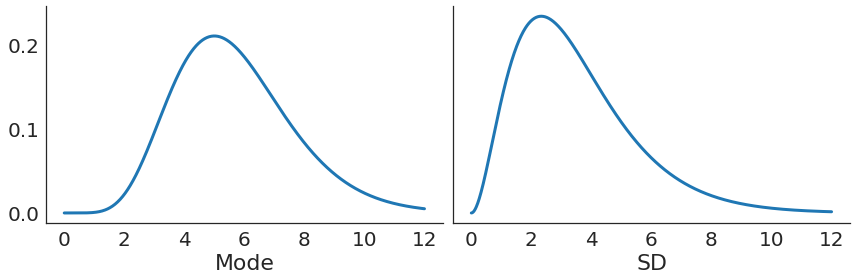

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import DataFrame
from scripts.spm_hrf import *
sns.set_style('white')
sns.set_context('notebook', font_scale=2)
%matplotlib inline

fig, axes = plt.subplots(1,2,figsize=(12,4), sharex=True, sharey=True)
t = np.linspace(0,12,1000)

axes[0].plot(t, gamma(t, *to_sr(5, 2)), linewidth=3)
axes[0].set(xlabel='Mode', xticks=np.arange(0,13,2))

axes[1].plot(t, gamma(t, *to_sr(2.33, 2)), linewidth=3)
axes[1].set(xlabel='SD')

sns.despine()
plt.tight_layout()

## Toy Example

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_626ca19e40460c16b93ea503e36ac45c NOW.
/home/szoro/Documents/software/anaconda3.6/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


Finished.
Inference for Stan model: anon_model_626ca19e40460c16b93ea503e36ac45c.
2 chains, each with iter=500; warmup=250; thin=1; 
post-warmup draws per chain=250, total post-warmup draws=500.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
M         4.97    0.01   0.25   4.43   4.81   4.98   5.14   5.45    337    1.0
S         2.33    0.01   0.28   1.84   2.14   2.32   2.49    3.0    416    1.0
A          0.2  1.1e-3   0.02   0.16   0.19    0.2   0.21   0.24    332    1.0
alpha      6.6    0.06   1.26   4.48    5.7    6.5   7.29   9.44    398    1.0
beta      1.12    0.01   0.23   0.72   0.97   1.11   1.26   1.65    431    1.0
yhat[0]    0.0     0.0    0.0    0.0    0.0    0.0    0.0    0.0    500    nan
yhat[1]   0.02  6.8e-4   0.01 6.3e-3   0.02   0.02   0.03   0.05    337    1.0
yhat[2]   0.15  9.5e-4   0.02   0.11   0.14   0.15   0.16   0.18    425    1.0
yhat[3]    0.2  1.1e-3   0.02   0.16   0.19    0.2   0.21   0.24    330    1.0
yhat[4]   0.14 

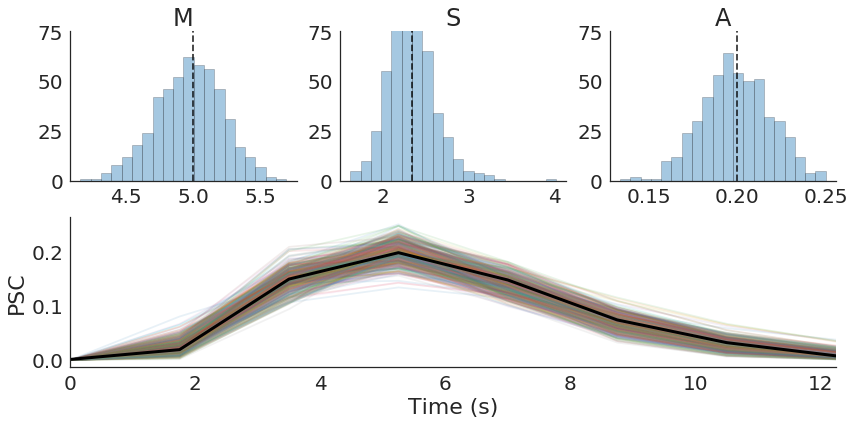

In [12]:
import os, pystan
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import DataFrame
from scripts.spm_hrf import *
sns.set_style('white')
sns.set_context('notebook', font_scale=2)
%matplotlib inline

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Data parameters.
n_subj = 20

## HRF parameters.
n_bins = 8
tr = 1.75

p = (5, 2.33, 0.2) # mode, sd, amplitude
noise = 0.01

## Sampling parameters.
iter = 500
chains = 2

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Generate data.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
np.random.seed(47404)

def single_gamma_hrf(t, m, s, a):
    yhat = gamma(t, *to_sr(m, s))
    return a * yhat / yhat.max()
    
## Simulate data.
t = np.arange(n_bins) * tr
y = np.array([single_gamma_hrf(t,*p) for _ in range(n_subj)])
y += np.random.normal(0, noise, size=y.shape)

## Assemble data.
data = dict(n_subj=n_subj, n_bins=n_bins, t=t, y=y)

## Assemble initial priors.
init = [dict( M = np.random.normal(5.00, 0.1),
              S = np.random.normal(2.33, 0.1),
              A = np.random.normal(0.00, 0.2))
        for _ in range(chains)]

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Fit model.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

fit = pystan.stan('sghrf_toy.stan', data=data, chains=chains, iter=iter, init=init, seed=47404)
print('Finished.')

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Visualize results.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

print(fit)

fig = plt.figure(figsize=(12,6))
results = fit.extract()

## Plot posterior distribution of parameters.
for n, param, v in zip(range(3), ['M','S','A'], p):
    ax = plt.subplot2grid((2,3),(0,n))
    sns.distplot(results[param], bins=20, kde=False, hist_kws=dict(linewidth=0.5, edgecolor='k'), ax=ax)
    ax.vlines(v, 0, 75, linestyle='--', alpha=0.8)
    ax.set(title=param, ylim=(0,75))
    
## Plot generated gamma HRF.
ax = plt.subplot2grid((2,3),(1,0),colspan=3)
ax.plot(t, y.mean(axis=0), linewidth=3, color='k')
ax.plot(t, results['yhat'].T, alpha=0.1, zorder=0)
ax.set(xlim=(t.min(), t.max()), xlabel='Time (s)', ylabel='PSC')
    
sns.despine()
plt.tight_layout()